In [21]:
import tensorflow as tf
import utils as u
import optimizers as opt
from copy import deepcopy
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [22]:
(x, y, z) = u.generate_data(N=500, random_ax=True, noise_scale=0.1, mesh=False)

In [23]:
deg = 11
D = u.build_design_matrix(X=x, Y=y, degree=deg)


In [24]:
D.shape

(500, 78)

In [25]:
*X_train, X_test, Z_train, Z_test = train_test_split(D, np.squeeze(z), test_size=0.33, shuffle=False)

In [26]:
[X_train, X_test, Z_train, Z_test] = [tf.constant(arr, dtype=tf.float32) for arr in (X_train, X_test, Z_train, Z_test)]

In [27]:
def linear_model(x, model):
    return tf.reduce_sum(x*model, axis=1)

In [28]:
def mse(Z_true, Z_pred):
    return tf.reduce_mean(((Z_true - Z_pred)**2))

In [29]:
from matplotlib import pyplot as plt

In [30]:
init_beta = tf.random.normal([D.shape[1]], 0, 0.01)


In [31]:
init_beta

<tf.Tensor: shape=(78,), dtype=float32, numpy=
array([-2.2185458e-02, -1.2512965e-02, -4.9891695e-04,  6.8062479e-03,
       -4.4968096e-03,  7.5306569e-04, -1.6909070e-02, -1.3236453e-02,
        3.9395504e-03, -6.2739300e-03, -4.0625236e-03, -9.3452809e-03,
       -7.1216864e-03,  8.5833156e-03, -1.7098311e-02,  2.3732895e-03,
       -1.5252434e-02,  4.2146975e-03, -1.0836935e-02,  7.3934654e-03,
       -1.6104737e-04,  2.2958581e-04, -2.2220775e-03, -4.6976157e-03,
       -1.2038828e-02,  1.8613436e-03,  2.2001063e-02, -1.4024825e-02,
        2.4054488e-02,  1.6582236e-02,  1.2118243e-02, -3.9212923e-03,
        2.2745550e-02,  1.1583918e-03, -3.5667188e-05, -8.7728705e-03,
       -1.7756714e-03,  1.3800789e-02, -1.9357100e-02, -1.3974331e-03,
        1.2133368e-02,  8.9577502e-03, -3.2268884e-03, -1.0664477e-02,
       -9.1337413e-03,  6.4023044e-03,  1.1362831e-02,  8.0046110e-04,
        1.1638545e-02, -3.7056636e-03,  9.0339649e-03, -1.1460458e-02,
        2.1254022e-03,  9.0904

In [32]:
def experiment_loop(x, y, init_beta, init_optimizer, batch_size = None,  l2_reg = 0., degrees = range(1, 6), n_steps=1000):
    training_log = dict()
    for degree in degrees:
        D = u.build_design_matrix(X=x, Y=y, degree=degree)
        optimizer = deepcopy(init_optimizer)
        X_train, X_test, Z_train, Z_test = train_test_split(D, np.squeeze(z), test_size=0.33, shuffle=False)
        [X_train, X_test, Z_train, Z_test] = [tf.constant(arr, dtype=tf.float32) for arr in (X_train, X_test, Z_train, Z_test)]
        if not batch_size:
            batch_size = X_train.shape[0]
        model_params = tf.Variable(init_beta[:D.shape[1]])

        loss_history = {'train_loss': list(), 'test_loss': list()}
        for epoch in tqdm(range(n_steps)):
            random_idx = np.random.permutation(X_train.shape[0])
            X_train, Z_train = tf.gather(X_train, random_idx), tf.gather(Z_train, random_idx)
            n_batches = (X_train.shape[0] // batch_size) + 1
            for ii in range(n_batches):
                X_batch = X_train[ii*batch_size : (ii+1)*batch_size, :]
                Z_batch = Z_train[ii*batch_size : (ii+1)*batch_size]
                with tf.GradientTape() as tape:
                    Z_pred = linear_model(X_batch, model_params)
                    batch_loss = mse(Z_batch, Z_pred) + l2_reg*tf.reduce_sum(model_params**2)
                batch_gradients = tape.gradient(batch_loss, model_params)
                optimizer.apply_gradients(batch_gradients, model_params)
            loss_history['train_loss'].append(mse(Z_train, linear_model(X_train, model_params)))
            loss_history['test_loss'].append(mse(Z_test, linear_model(X_test, model_params)))
        training_log[degree] = loss_history
    return training_log



## Plain gradient descent with a fixed learning rate (lr=0.01)

In [33]:
n_steps = 1000
degrees = range(1, 6)
lr = 0.001
l2_reg = 0. # OLS
optimizer = opt.SGD(lr = lr)
history_GD = experiment_loop(x, y, init_beta, optimizer)
    #print(f'Epoch {epoch} loss: {cross_entropy(Z_train, logistic_function(X_train, model_params))}')


100%|██████████| 1000/1000 [00:05<00:00, 198.85it/s]


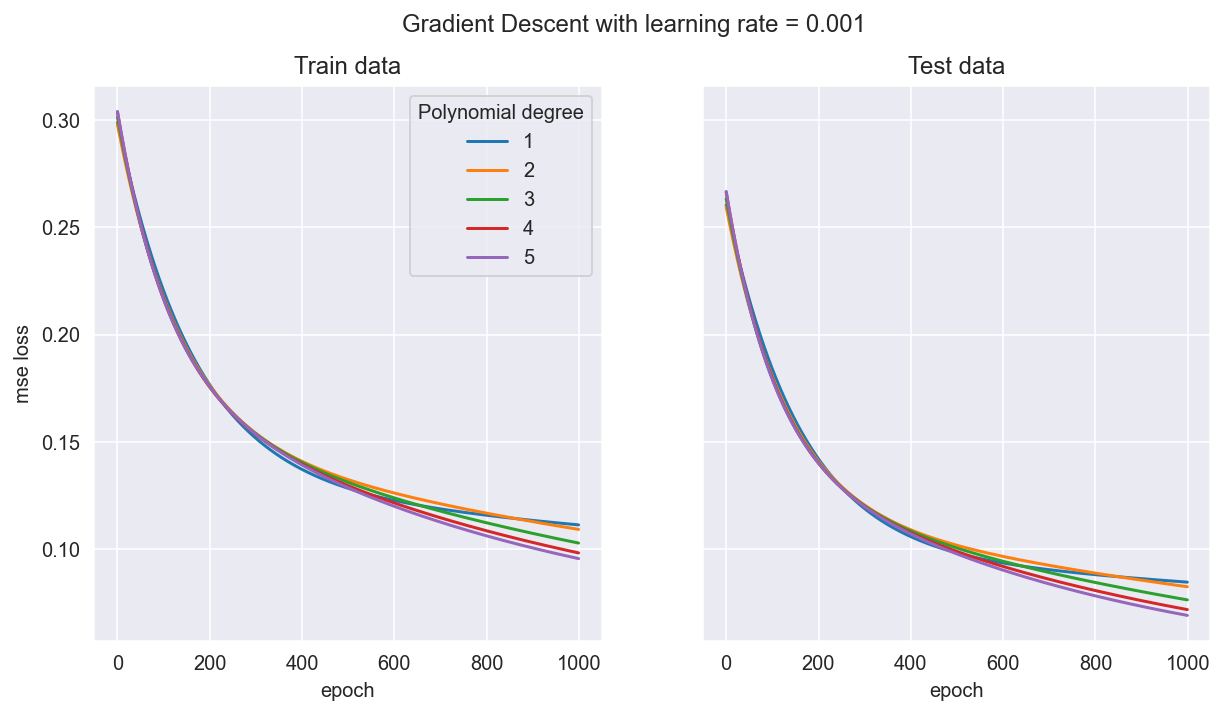

In [34]:
fix, ax = plt.subplots(1, 2, dpi=144, figsize=(10, 5), sharey=True)
for key in degrees:
    ax[0].plot(range(n_steps), history_GD[key]['train_loss'], label=key)
    ax[1].plot(range(n_steps), history_GD[key]['test_loss'], label=key)
#ax[0].set_ylim(0.65, 0.8)
#ax[0].set_xlim(0, 30)
#ax[1].set_xlim(0, 30)
ax[0].legend(title='Polynomial degree')
ax[0].set_title('Train data')
ax[1].set_title('Test data')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('mse loss')

ax[1].set_xlabel('epoch')
fix.suptitle('Gradient Descent with learning rate = 0.001')
plt.savefig('results/part_f/gd_lr0001_mse.png')

## Gradient descent with momentum

In [35]:
lr = 0.1
l2_reg = 0. # OLS
momentum_rates = np.arange(0, 11) / 10.
history_GD_momentum = dict()
for rate in momentum_rates:
    history_GD_momentum[rate] = experiment_loop(x, y, init_beta, opt.SGD(lr = lr, momentum_rate=rate))
    #print(f'Epoch {epoch} loss: {cross_entropy(Z_train, logistic_function(X_train, model_params))}')

100%|██████████| 1000/1000 [00:04<00:00, 218.64it/s]


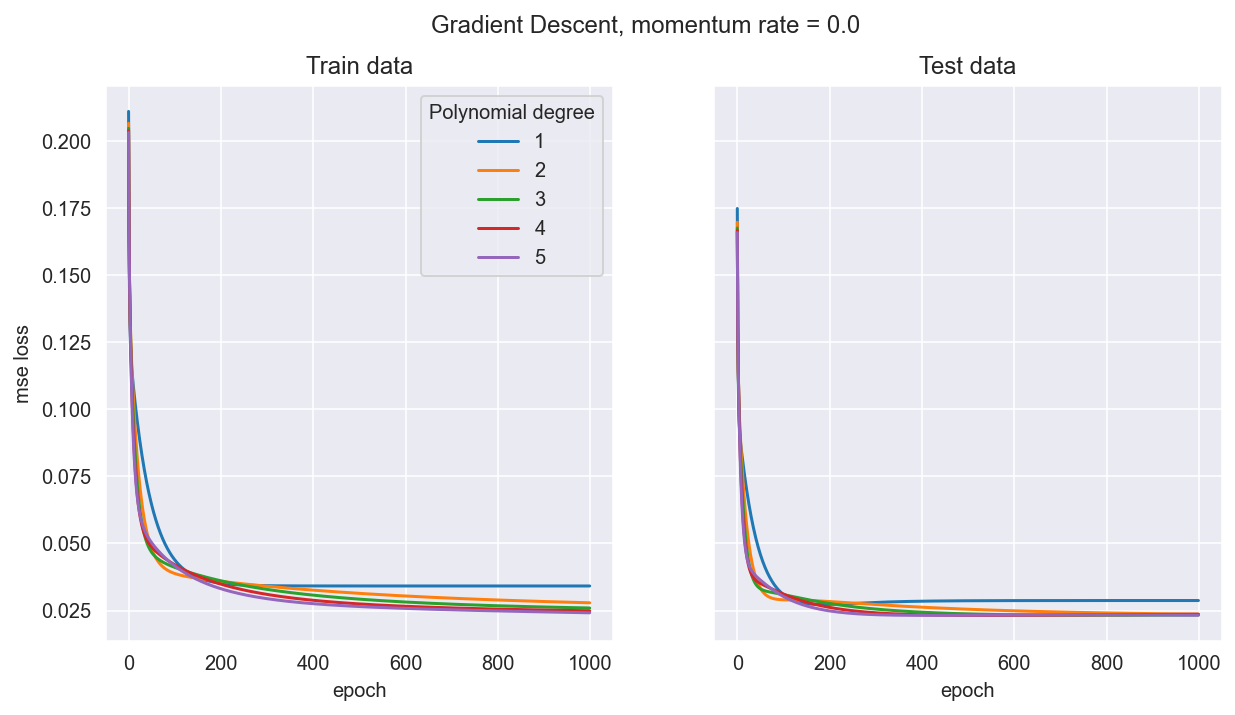

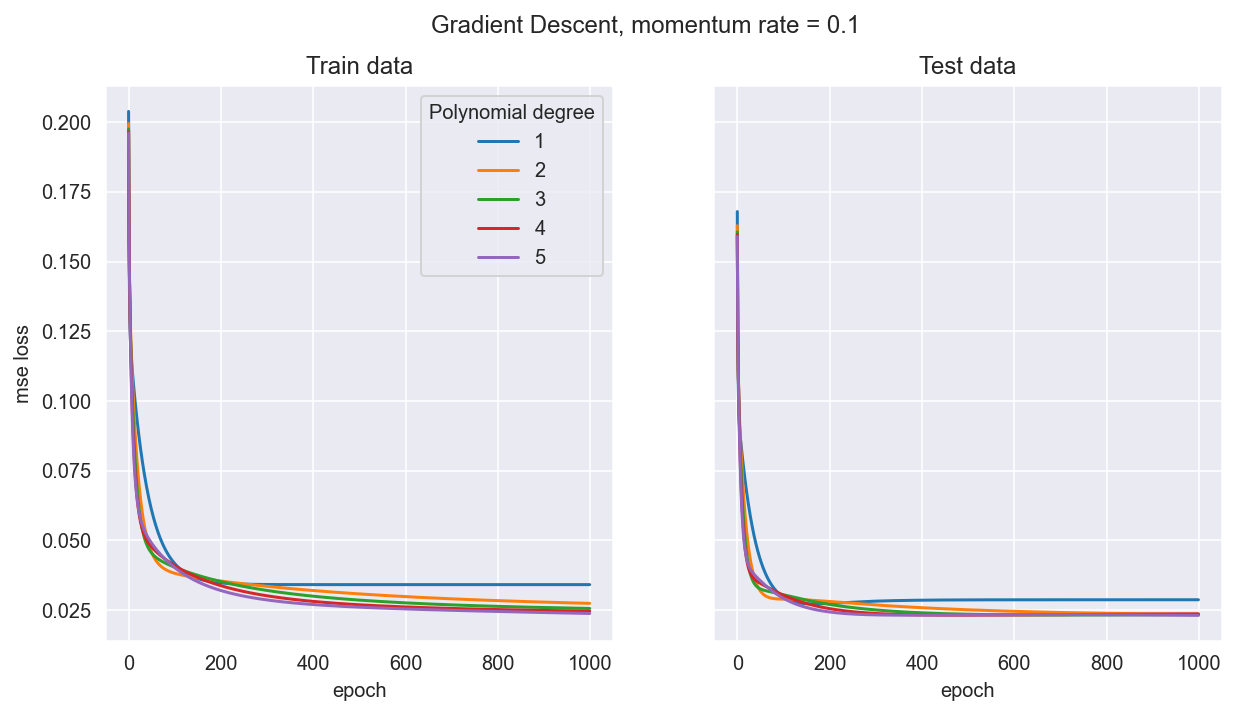

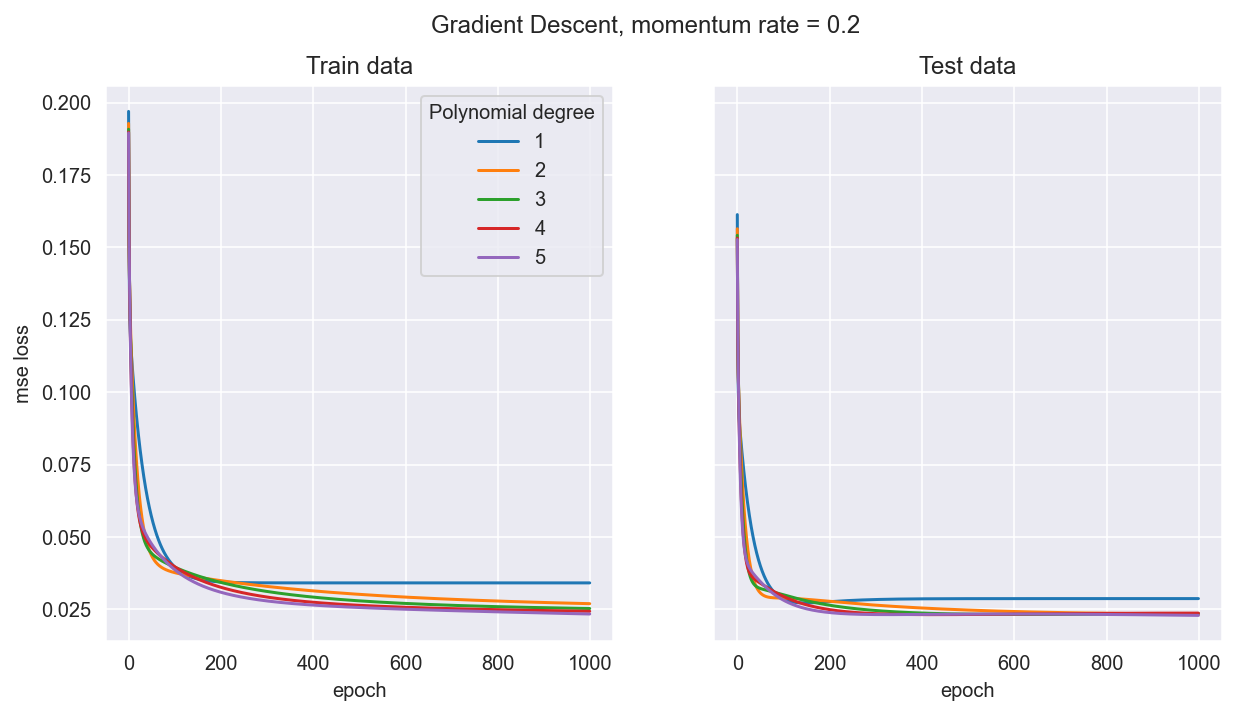

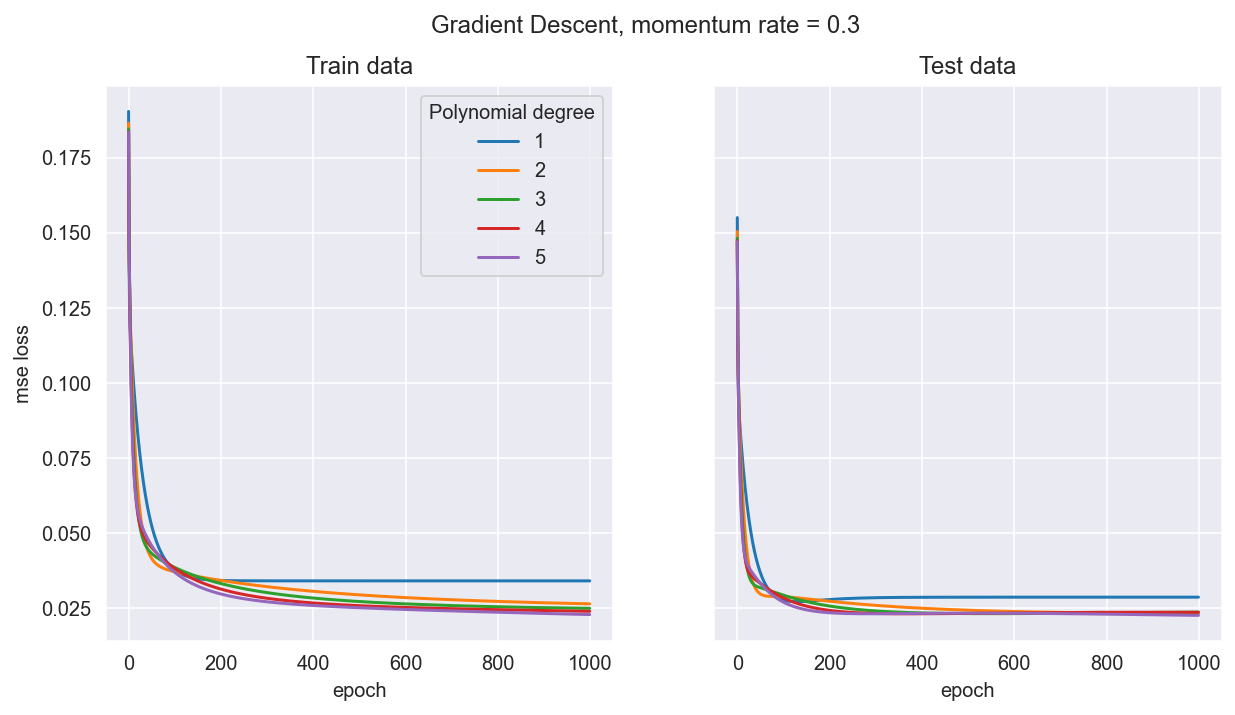

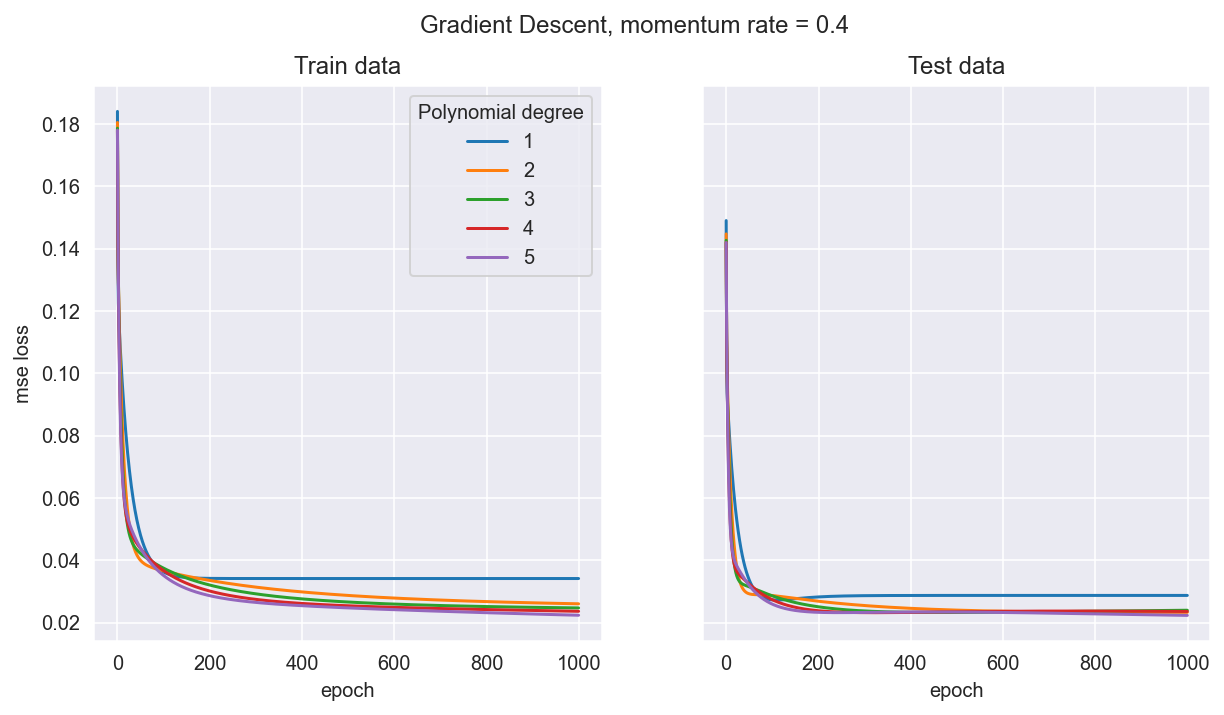

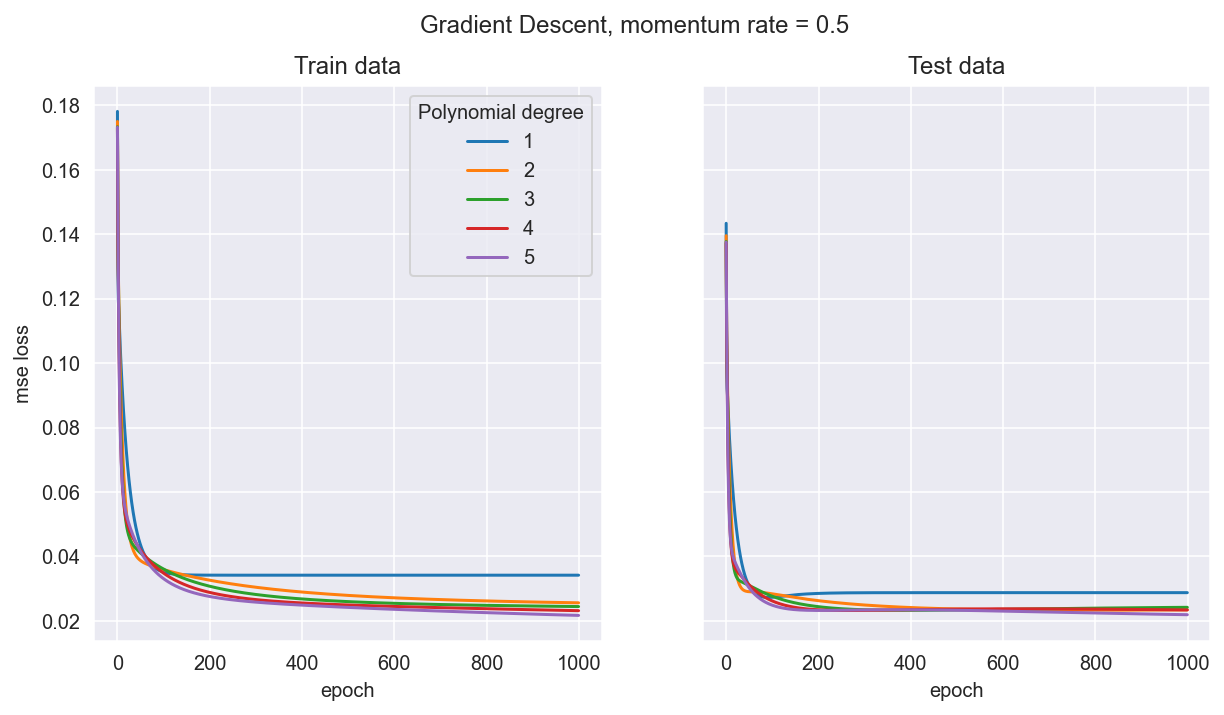

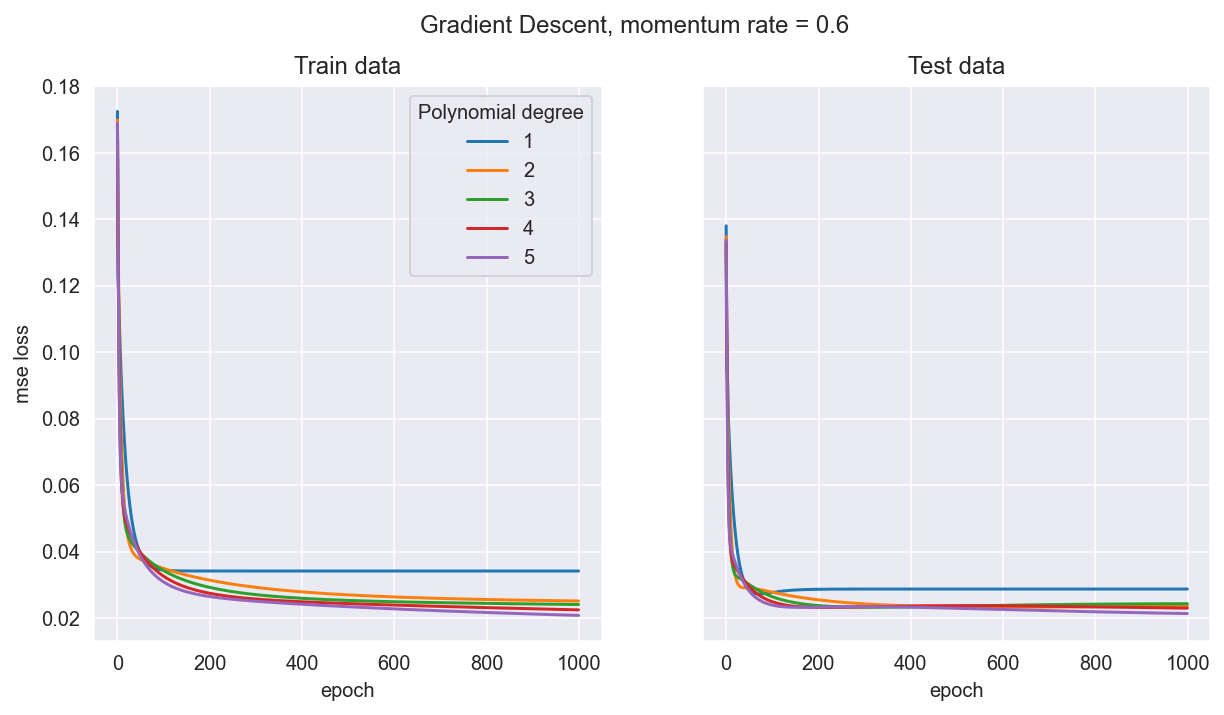

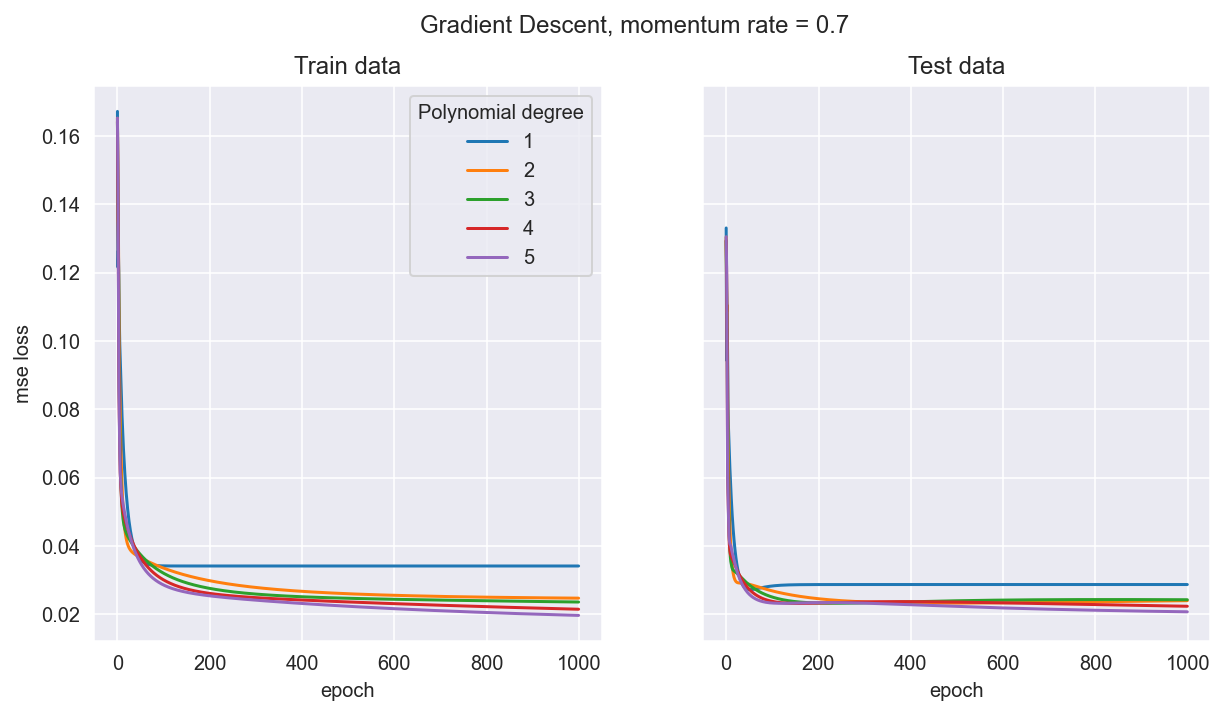

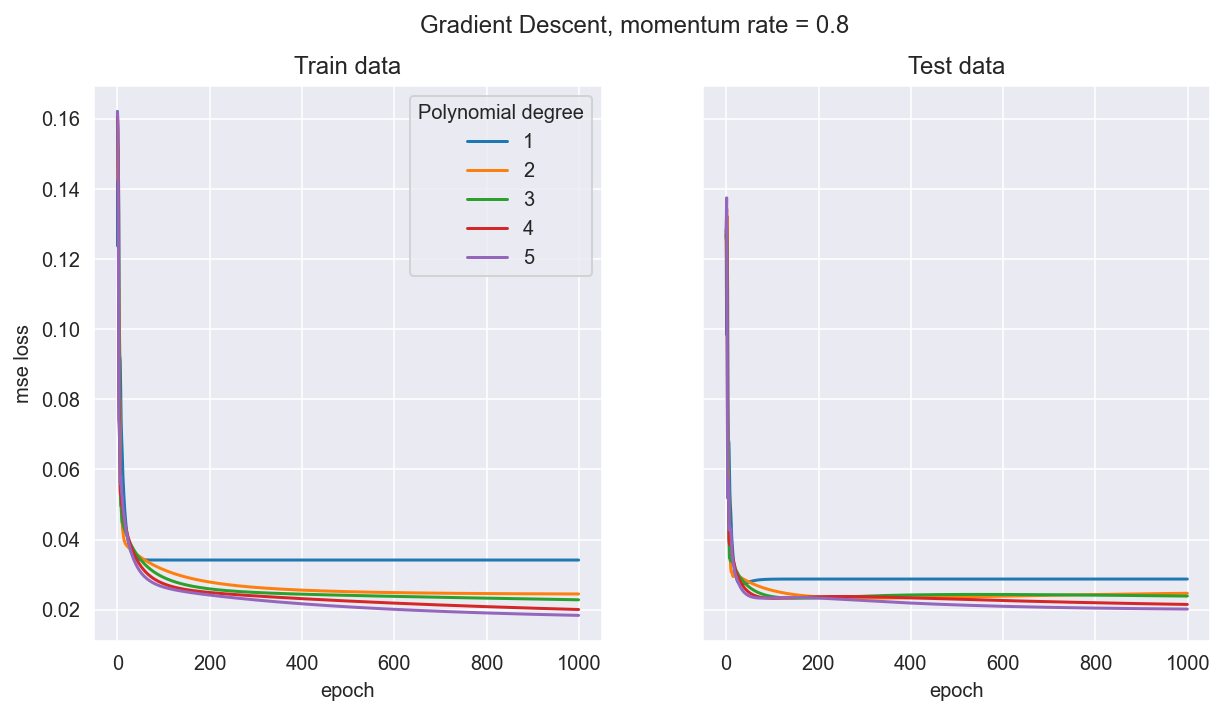

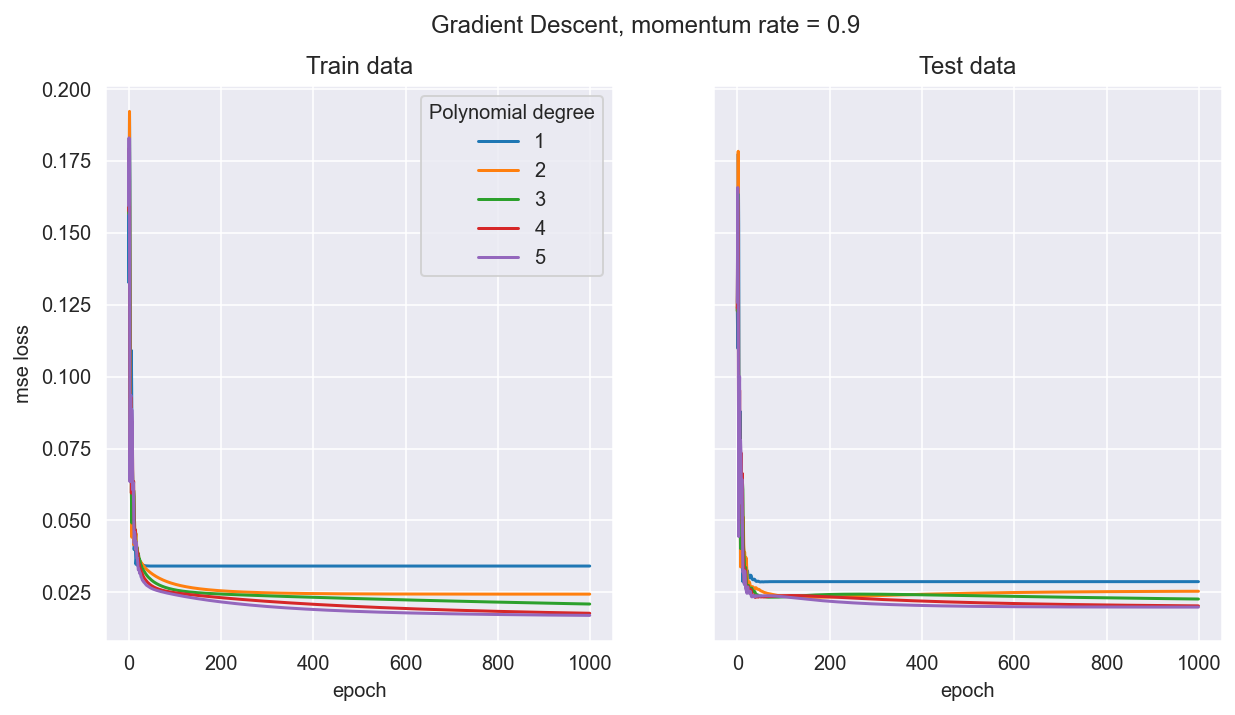

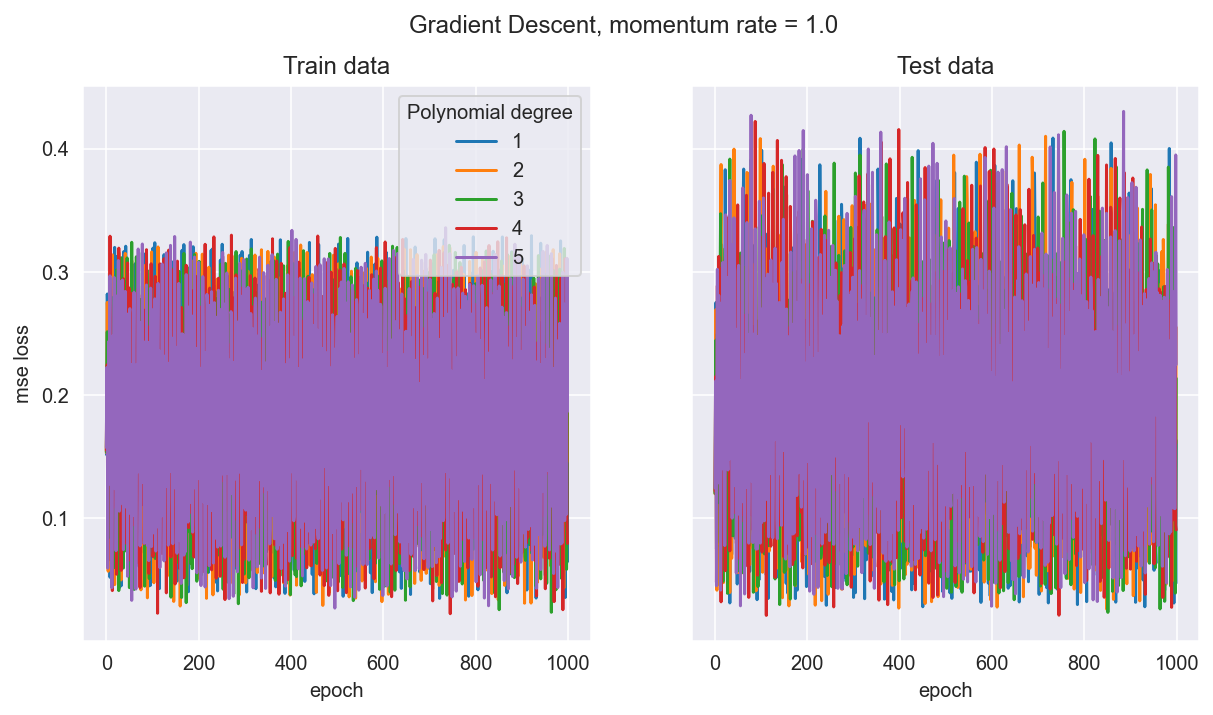

In [36]:
for row, rate in enumerate(momentum_rates):
    fix, ax = plt.subplots(1, 2, dpi=144, figsize=(10, 5), sharey=True)
    for key in degrees:
        ax[0].plot(range(n_steps), history_GD_momentum[rate][key]['train_loss'], label=key)
        ax[1].plot(range(n_steps), history_GD_momentum[rate][key]['test_loss'], label=key)

    ax[0].legend()
    #ax[0].set_ylim(0.65, 0.8)
    #ax[0].set_xlim(0, 30)
    #ax[1].set_xlim(0, 30)

    #ax[0,:].legend()
    ax[0].legend(title='Polynomial degree')
    ax[0].set_title('Train data')
    ax[1].set_title('Test data')
    ax[0].set_xlabel('epoch')
    ax[1].set_xlabel('epoch')
    ax[0].set_ylabel('mse loss')
    fix.suptitle(f'Gradient Descent, momentum rate = {rate}')
    #plt.show()
    plt.savefig(f'results/part_f/gd_momentum_{rate}_mse.png')

In [37]:
history_GD_momentum[0.0].keys()

dict_keys([1, 2, 3, 4, 5])

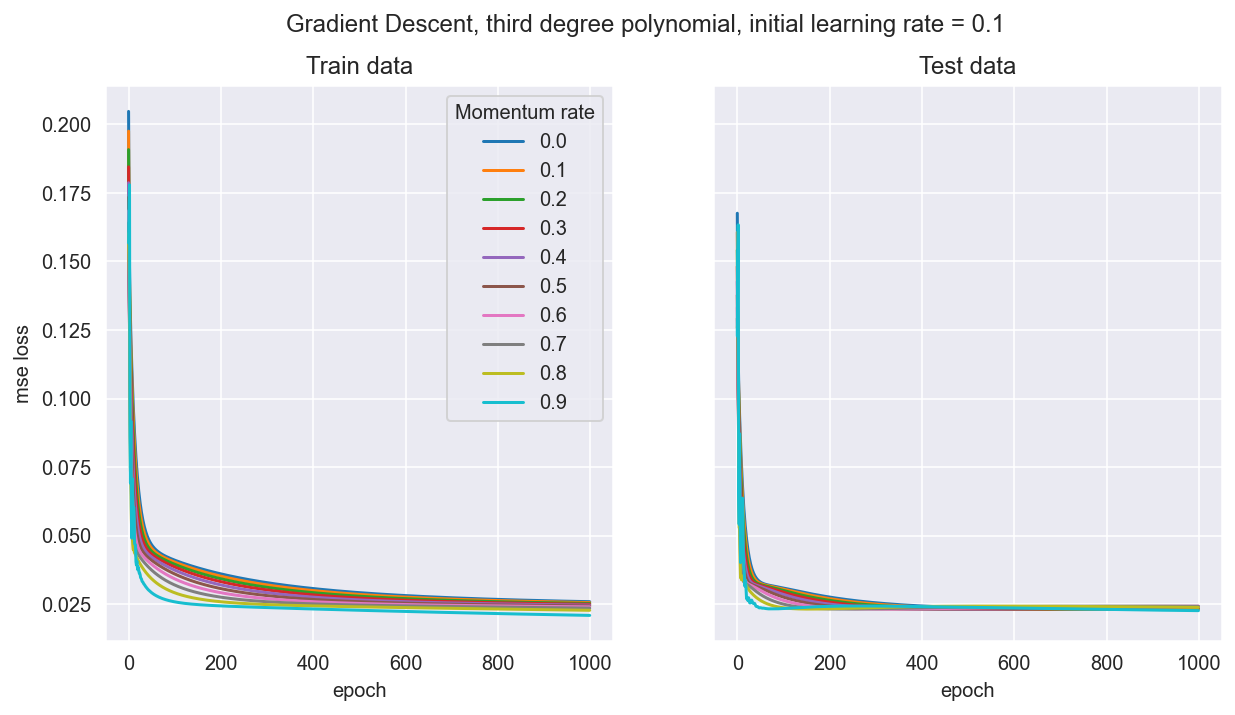

In [38]:
fix, ax = plt.subplots(1, 2, dpi=144, figsize=(10, 5), sharey=True)
for rate in momentum_rates[:-1]:
    ax[0].plot(range(n_steps), history_GD_momentum[rate][3]['train_loss'], label=rate)
    ax[1].plot(range(n_steps), history_GD_momentum[rate][3]['test_loss'], label=rate)

#ax[0].set_xlim((0, 50))
#ax[1].set_xlim((0, 50))

ax[0].legend(title='Momentum rate')
ax[0].set_title('Train data')
ax[1].set_title('Test data')
ax[0].set_xlabel('epoch')
ax[1].set_xlabel('epoch')
ax[0].set_ylabel('mse loss')

fix.suptitle(f'Gradient Descent, third degree polynomial, initial learning rate = 0.1')
#plt.show()
plt.savefig(f'results/part_f/gd_lr01_momentum_multirate_3rd_degree_mse.png')


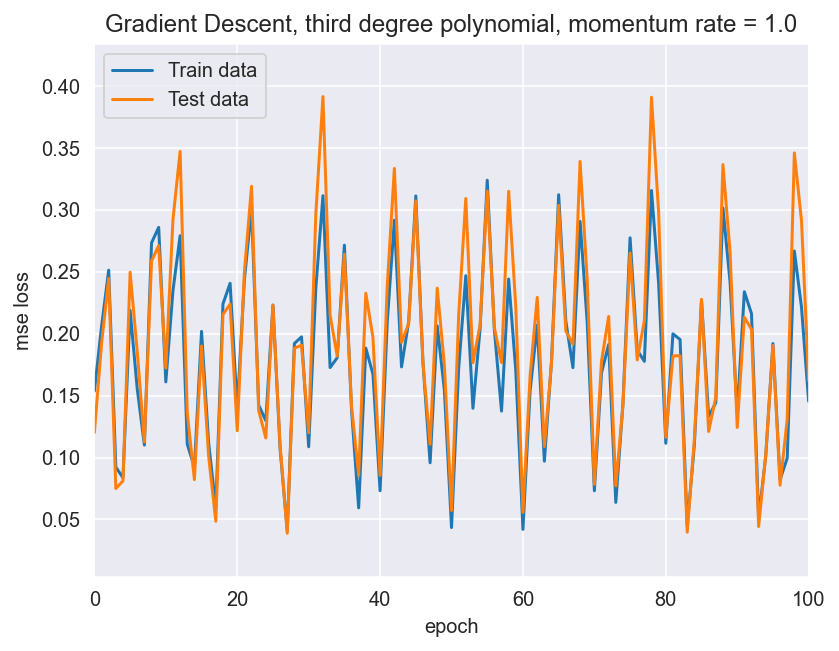

In [39]:
fig, ax = plt.subplots(dpi=144)
ax.plot(range(n_steps), history_GD_momentum[1.0][3]['train_loss'], label='Train data')
ax.plot(range(n_steps), history_GD_momentum[1.0][3]['test_loss'], label='Test data')
ax.set_title('Gradient Descent, third degree polynomial, momentum rate = 1.0')
ax.set_xlim((0, 100))
ax.set_ylabel('mse loss')
ax.legend()
ax.set_xlabel('epoch')
plt.savefig(f'results/part_f/gd_momentum_1_3rd_degree_mse.png')



## Stochastic gradient descent with momentum

In [40]:
lr = 0.01
l2_reg = 0. # OLS
momentum_rates = np.arange(0, 11) / 10.
history_SGD_momentum = dict()
batch_size = 50
for rate in momentum_rates:
    history_SGD_momentum[rate] = experiment_loop(x, y, init_beta, opt.SGD(lr = lr, momentum_rate=rate), batch_size=batch_size)
    #print(f'Epoch {epoch} loss: {cross_entropy(Z_train, logistic_function(X_train, model_params))}')

100%|██████████| 1000/1000 [00:14<00:00, 68.97it/s]


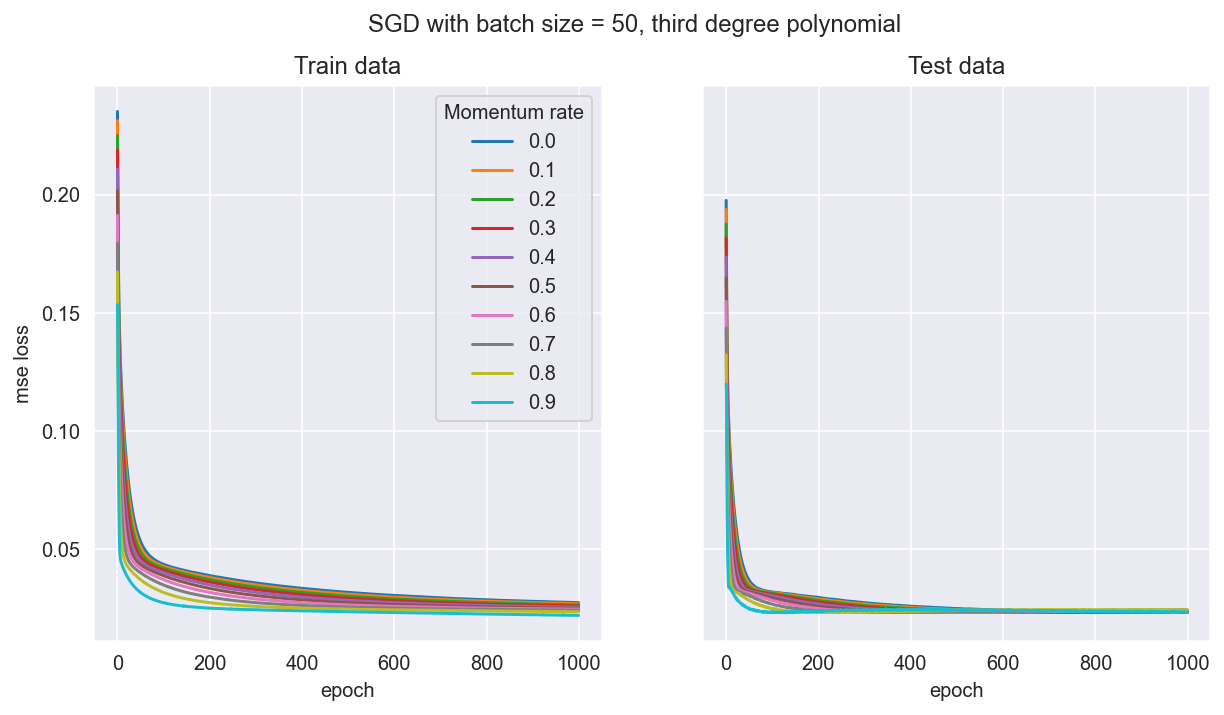

In [41]:
fix, ax = plt.subplots(1, 2, dpi=144, figsize=(10, 5), sharey=True)
for rate in momentum_rates[:-1]:
    ax[0].plot(range(n_steps), history_SGD_momentum[rate][3]['train_loss'], label=rate)
    ax[1].plot(range(n_steps), history_SGD_momentum[rate][3]['test_loss'], label=rate)

#ax[0].set_xlim((0, 20))
#ax[1].set_xlim((0, 20))
ax[0].legend(title='Momentum rate')
ax[0].set_title('Train data')
ax[1].set_title('Test data')
ax[0].set_xlabel('epoch')
ax[1].set_xlabel('epoch')
ax[0].set_ylabel('mse loss')

fix.suptitle(f'SGD with batch size = 50, third degree polynomial')
plt.savefig(f'results/part_f/sgd50_momentum_multirate_3rd_degree_mse.png')



Repeat the analysis for a fixed momentum and learning rate, but different batch sizes

In [42]:
lr = 0.01
l2_reg = 0. # OLS
history_SGD_batchsize = dict()
batch_sizes = [10, 50, 100, 150, x.shape[0]]
for batch_size in batch_sizes:
    history_SGD_batchsize[batch_size] = experiment_loop(x, y, init_beta, opt.SGD(lr = lr, momentum_rate=0.1), batch_size=batch_size, degrees=[3])
    #print(f'Epoch {epoch} loss: {cross_entropy(Z_train, logistic_function(X_train, model_params))}')

100%|██████████| 1000/1000 [00:02<00:00, 368.02it/s]


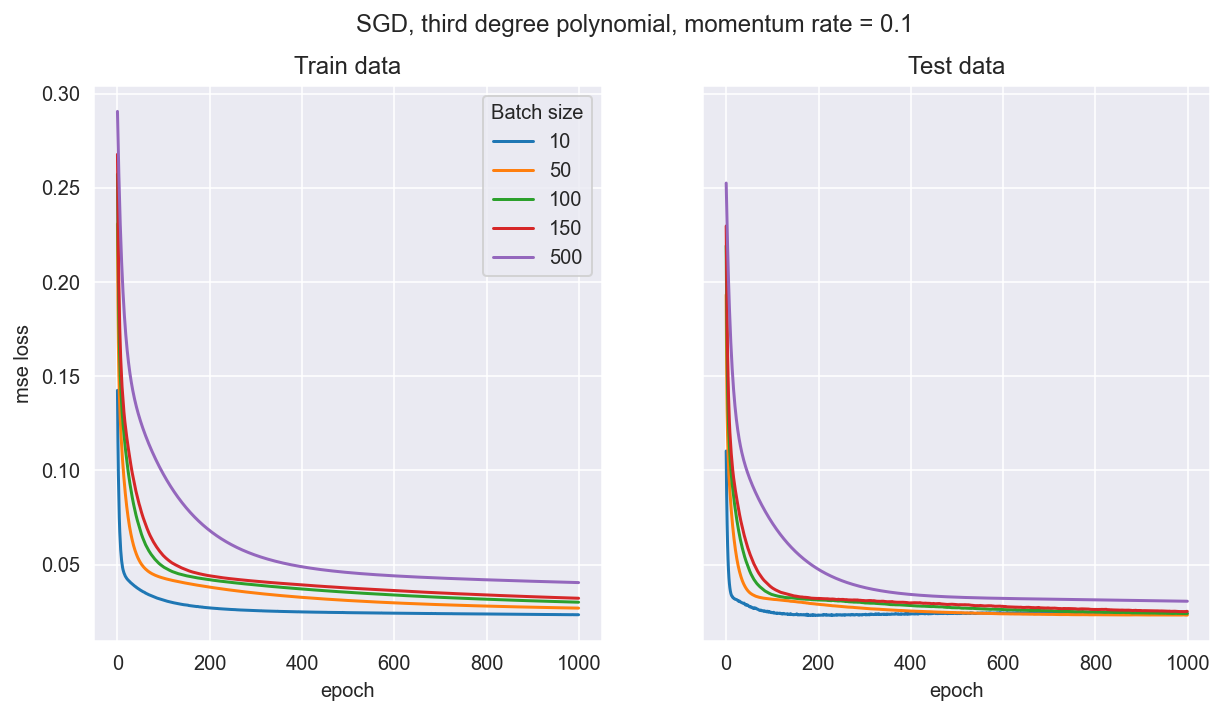

In [43]:
fix, ax = plt.subplots(1, 2, dpi=144, figsize=(10, 5), sharey=True)
for batch_size in batch_sizes:
    ax[0].plot(range(n_steps), history_SGD_batchsize[batch_size][3]['train_loss'], label=batch_size)
    ax[1].plot(range(n_steps), history_SGD_batchsize[batch_size][3]['test_loss'], label=batch_size)

#ax[0].set_ylim((0.6, 1.3))
#ax[1].set_xlim((0, 20))
ax[0].legend(title='Batch size')
ax[0].set_title('Train data')
ax[1].set_title('Test data')
ax[0].set_xlabel('epoch')
ax[1].set_xlabel('epoch')
ax[0].set_ylabel('mse loss')

fix.suptitle(f'SGD, third degree polynomial, momentum rate = 0.1')
plt.savefig(f'results/part_f/sgd_batch_multisize__3rd_degree_mse.png')


## Tuning the learning rate with Adagrad

In [44]:
lr = 0.01
l2_reg = 0. # OLS
history_adagrad = dict()

batch_sizes = [10, 50, 100, 150, x.shape[0]]
for batch_size in batch_sizes:
    history_adagrad[batch_size] = experiment_loop(x, y, init_beta, opt.AdaGrad(lr = lr, var_shape=(10)), batch_size=batch_size, degrees=[3], n_steps=1000)


100%|██████████| 1000/1000 [00:02<00:00, 392.47it/s]


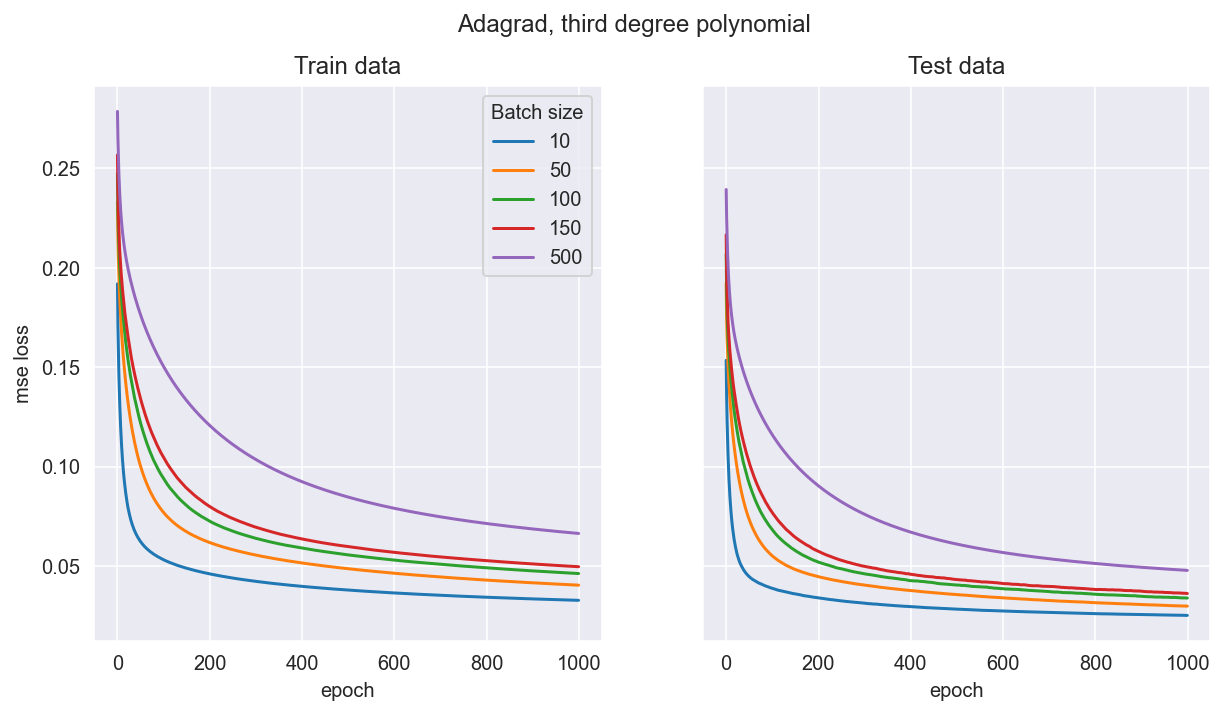

In [56]:
fix, ax = plt.subplots(1, 2, dpi=144, figsize=(10, 5), sharey=True)
for batch_size in batch_sizes:
    ax[0].plot(range(1000), history_adagrad[batch_size][3]['train_loss'], label=batch_size)
    ax[1].plot(range(1000), history_adagrad[batch_size][3]['test_loss'], label=batch_size)

#ax[0].set_xlim((600, 1000))
#ax[1].set_xlim((600, 1000))
#ax[0].set_ylim((0.01, 0.1))

ax[0].legend(title='Batch size')
ax[0].set_title('Train data')
ax[1].set_title('Test data')
ax[0].set_xlabel('epoch')
ax[1].set_xlabel('epoch')
ax[0].set_ylabel('mse loss')
fix.suptitle(f'Adagrad, third degree polynomial')

plt.savefig(f'results/part_f/adagrad_3rd_degree_mse.png')


## Tuning the learning rate with RMSProp

In [46]:
lr = 0.01
l2_reg = 0. # OLS
history_rmsprop = dict()

batch_sizes = [10, 50, 100, 150, x.shape[0]]
for batch_size in batch_sizes:
    history_rmsprop[batch_size] = experiment_loop(x, y, init_beta, opt.RMSProp(lr = lr, var_shape=(10)), batch_size=batch_size, degrees=[3])

100%|██████████| 1000/1000 [00:02<00:00, 341.13it/s]


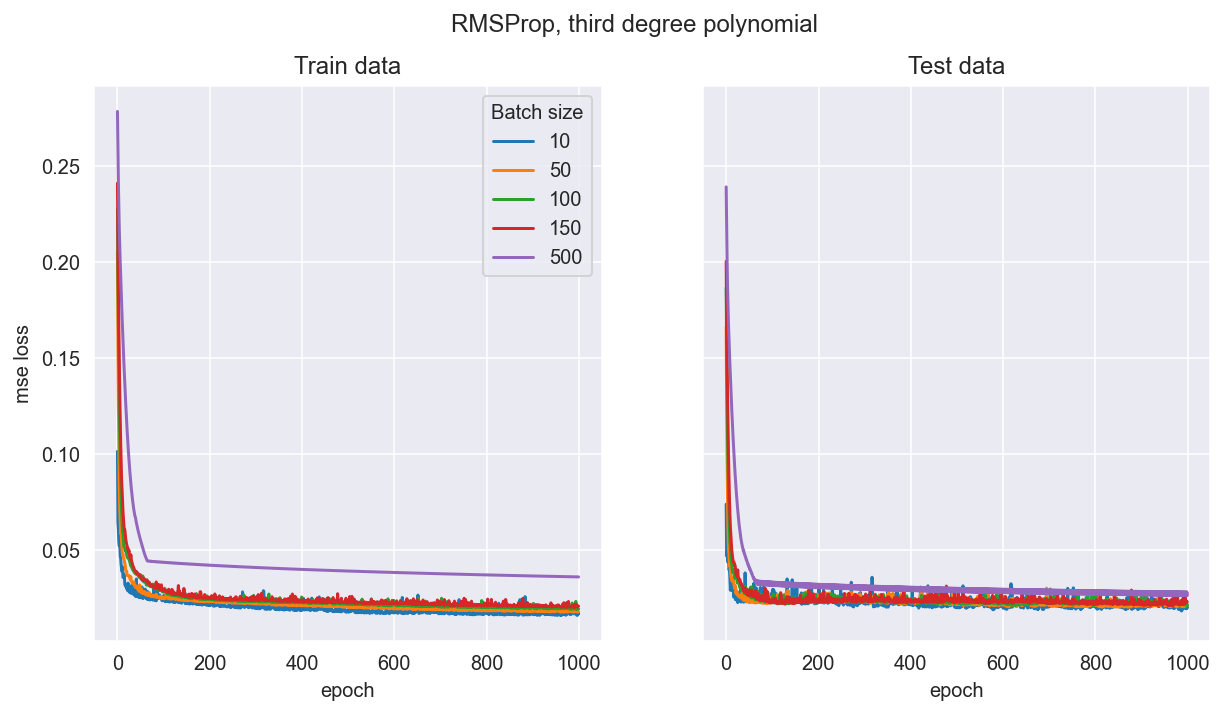

In [47]:
fix, ax = plt.subplots(1, 2, dpi=144, figsize=(10, 5), sharey=True)
for batch_size in batch_sizes:
    ax[0].plot(range(1000), history_rmsprop[batch_size][3]['train_loss'], label=batch_size)
    ax[1].plot(range(1000), history_rmsprop[batch_size][3]['test_loss'], label=batch_size)

#ax[0].set_xlim((0, 100))
#ax[1].set_xlim((0, 100))
#ax[0].set_ylim((0., 0.21))
ax[0].legend(title='Batch size')
ax[0].set_title('Train data')
ax[1].set_title('Test data')
ax[0].set_xlabel('epoch')
ax[1].set_xlabel('epoch')
ax[0].set_ylabel('mse loss')
fix.suptitle(f'RMSProp, third degree polynomial')

plt.savefig(f'results/part_f/rms_3rd_degree_mse.png')

## Tuning the learning rate with ADAM

In [48]:
lr = 0.01
l2_reg = 0.  # OLS
history_adam = dict()

batch_sizes = [10, 50, 100, 150, x.shape[0]]
for batch_size in batch_sizes:
    history_adam[batch_size] = experiment_loop(x, y, init_beta, opt.RMSProp(lr=lr, var_shape=(10)),
                                                  batch_size=batch_size, degrees=[3])


100%|██████████| 1000/1000 [00:02<00:00, 370.74it/s]


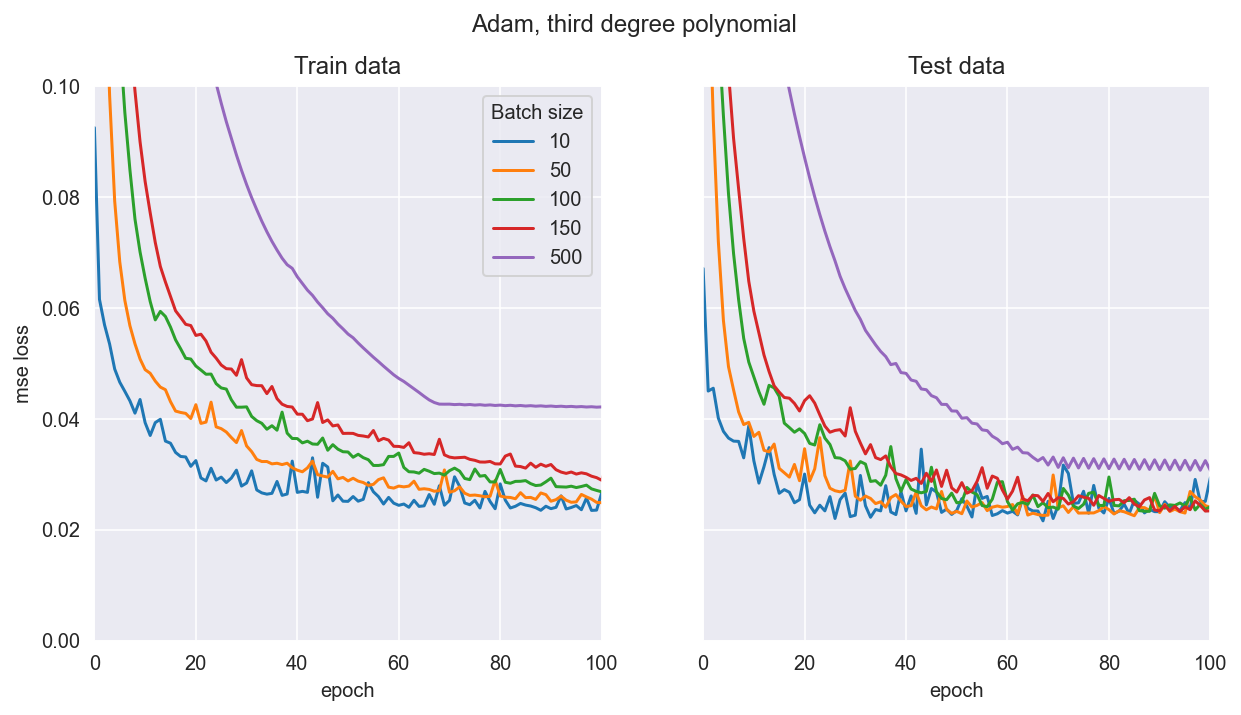

In [49]:
fix, ax = plt.subplots(1, 2, dpi=144, figsize=(10, 5), sharey=True)
for batch_size in batch_sizes:
    ax[0].plot(range(1000), history_adam[batch_size][3]['train_loss'], label=batch_size)
    ax[1].plot(range(1000), history_adam[batch_size][3]['test_loss'], label=batch_size)

ax[0].set_xlim((0, 100))
ax[1].set_xlim((0, 100))
ax[0].set_ylim((0, 0.1))
ax[0].legend(title='Batch size')
ax[0].set_title('Train data')
ax[1].set_title('Test data')
ax[0].set_xlabel('epoch')
ax[1].set_xlabel('epoch')
ax[0].set_ylabel('mse loss')
fix.suptitle(f'Adam, third degree polynomial')

plt.savefig(f'results/part_f/adam_3rd_degree_mse_zoom.png')

## Scikit-learn's SGD model

In [50]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [51]:
for degree in range(1, 10):
    D = u.build_design_matrix(X=x, Y=y, degree=degree)
    X_train, X_test, Z_train, Z_test = train_test_split(D, np.squeeze(z), test_size=0.33, shuffle=False)
    #reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=100, tol=1e-3, learning_rate='constant'))
    reg = SGDRegressor(max_iter=100, tol=1e-3, penalty=None,learning_rate='constant')
    reg.fit(X_train, Z_train)
    print('Degree: ', degree)
    print('Train MSE: ', mse(Z_train, reg.predict(X_train)).numpy())
    print('Train COD: ', reg.score(X_train, Z_train))
    print('Test MSE: ', mse(Z_test, reg.predict(X_test)).numpy())
    print('Test COD: ', reg.score(X_test, Z_test))

Degree:  1
Train MSE:  0.03465653376243802
Train COD:  0.6474534244166451
Test MSE:  0.027949286722877956
Test COD:  0.6226800025976986
Degree:  2
Train MSE:  0.03615771831340249
Train COD:  0.6321824952351824
Test MSE:  0.028275143330216357
Test COD:  0.6182808844572772
Degree:  3
Train MSE:  0.036171091263920645
Train COD:  0.6320464577438701
Test MSE:  0.027991620738661648
Test COD:  0.6221084863767692
Degree:  4
Train MSE:  0.0347381547565719
Train COD:  0.6466231278216406
Test MSE:  0.028000058849602515
Test COD:  0.6219945704822473
Degree:  5
Train MSE:  0.031138989811397108
Train COD:  0.6832359433178135
Test MSE:  0.023908341833398104
Test COD:  0.6772334275319138
Degree:  6
Train MSE:  0.030709378490502565
Train COD:  0.6876062014934123
Test MSE:  0.02493889908305208
Test COD:  0.6633207340661422
Degree:  7
Train MSE:  0.02996908751064288
Train COD:  0.6951368752668998
Test MSE:  0.02494008067667061
Test COD:  0.6633047823566944
Degree:  8
Train MSE:  0.029313796019299638
Trai

In [52]:
reg.coef_.shape

(55,)